In [1]:
import os
import numpy as np
import pandas as pd

## 데이터 확보

In [2]:
from pymongo import MongoClient
# from dotenv import load_dotenv

# load_dotenv(verbose=True,dotenv_path='./env')

# mongoDB 설정
mongo_host = "localhost"
mongo_port = 27020
mongo_user = "churros"
mongo_passwd = "A503"
mongo_db_name = "newsdb"
mongo_client = MongoClient(host=mongo_host, port=mongo_port, username=mongo_user, password=mongo_passwd)


db = mongo_client[mongo_db_name]
collection = db['newsCol']
tokencollection = db['newsToken'] # token collection

In [3]:
data = list(collection.find())


## gensim library 를 활용한 LDA

### 전처리

In [18]:
from konlpy.tag import  Komoran, Okt, Hannanum
# 형태소 분석 library import, jvm 필요
kom = Komoran()
okt = Okt()
han = Hannanum()
# komoran은 빈줄이 있으면 에러가 남
# komoran.morphs("\n".join([s for s in c[:40].split("\n") if s]))

In [19]:
# 중복 반복되는 단어 정규화
# from soynlp.normalizer import *
# repeat_normalize('와하하하하하하하하하핫', num_repeats=2)

In [20]:
# mecab = Mecab()
import re # 문자열 처리를 위한 정규표현식 패키지
from collections import Counter # 단어 등장 횟수 카운트
import pandas as pd

In [21]:
df_raw = pd.DataFrame(data)
df = df_raw.set_index("_idx")

In [10]:
# 분석에서 제외할 데이터 제거
df.reset_index(drop = True, inplace=True) # 인덱스 초기화

In [11]:
# 토큰화 이전 불필요한 글자들 전처리
# punctuation 삭제
PUNCTUATION = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
PUNCTUATION_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', } 
# 불필요한 부분 삭제(이메일, url등)
EMAIL_REGEX = re.compile(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)')
URL_REGEX = re.compile(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')
HANGUL_REGEX = re.compile(r'[ㄱ-ㅎㅏ-ㅣ]+')
HTML_REGEX = re.compile(r'<[^>]*>')
PUNCTUATION_REGEX = re.compile(r'[^\w\s\n]')
def clean_str(text):
    # Replace punctuations using dictionary lookup
    for p in PUNCTUATION:
        text = text.replace(p, f' {p} ')

    for p in PUNCTUATION_MAPPING:
        text = text.replace(p, PUNCTUATION_MAPPING[p])
    
    # Use compiled regular expressions
    text = EMAIL_REGEX.sub('', text)
    text = URL_REGEX.sub('', text)
    text = HANGUL_REGEX.sub('', text)
    text = HTML_REGEX.sub('', text)
    text = PUNCTUATION_REGEX.sub('', text)
    
    # Replace newlines with periods
    text = text.replace('\n', '.')
    
    return text.strip() 

동사를 원형으로 복원하도록 하겠습니다. 규칙은 다음과 같습니다.

1. NNG|NNP|NNB + XSV|XSA --> NNG|NNP|NNB + XSV|XSA + 다
2. NNG|NNP|NNB + XSA + VX --> NNG|NNP + XSA + 다
3. VV --> VV + 다
4. VX --> VX + 다

In [12]:
# 동사 원형 복원
p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
p4 = re.compile('[가-힣A-Za-z0-9]+/VX')
def stemming_text(text):
    corpus = []
    for sent in text:
        ori_sent = sent
        mached_terms = re.findall(p1, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
        mached_terms = re.findall(p2, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                if tag != 'VX':
                    modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p3, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p4, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        corpus.append((ori_sent))
    return corpus

In [13]:
## 임시 테스트 용 (전처리 속도 비교용)
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
def tokenstart(startidx, endidx):
    logging.info('Starting tokenwize')
    data = collection.find().skip(startidx).limit(endidx-startidx)
    data_list = list(data)
    df = pd.DataFrame(data_list)
    df["token"] = df["full_text"].apply(token)
    df_saving = df[["_idx", "token"]]
    records = df_saving.to_dict("records")
    logging.info('Ending tokenwize')
    return df_saving

def token(txt):
    okt = Okt()
    text = clean_str(txt)
    word_tokens = okt.pos(text, join="/", stem=True)
    stop_words_none = delete_stop_words(word_tokens)
    result = stemming_text(stop_words_none)
    return result
word_file = open("stopwords.txt", "r", encoding="utf-8")
words = word_file.read()
stop_words = set(words.split('\n'))
# lemmatization = {"VV","VX","NNG","NNP","NNB","XSV","XSA","SL","XR","SN","SH","SW","MAG","NF"}
lemmatization = {'Adjective', 'Adverb', 'Alpha', 'Exclamation', 'Foreign', 'Noun', 'Number',  'Unknown', 'Verb'} # 동사와 명사 형용사 및 기타 의미가 존재하는 형태소만을 남김
def delete_stop_words(text):
    result =  [word for word in text if (not (word.split('/')[0] in stop_words) and word.split('/')[1] in lemmatization)]
    return result


In [14]:
if "하다" in stop_words: print("true")

true


1. 바닐라 버전 : 10m 50.3s
2. punctuation 수정 버전 : 10m 7.5s
3. multiprocess 적용 버전 : 나가리
4. okt 모델 사용 : 30초
5. meccab 적용시켜보고는 싶다(이후에)

In [16]:
# 불용어 제거 및 특정 품사만 살리기
word_file = open("stopwords.txt", "r", encoding="utf-8")
words = word_file.read()
stop_words = set(words.split('\n'))
# 활용할 형태소 리스트
lemmatization = {"VV","VX","NNG","NNP","NNB","XSV","XSA","SL","XR","SN","SH","SW","MAG","NF"}

def token(txt):
    txt = clean_str(txt)
    word_tokens = kom.pos(txt, join="/")
    cleared = [word for word in word_tokens if (not (word.split('/')[0] in stop_words) and word.split('/')[1] in lemmatization)]
    result = stemming_text(cleared)
    return result
df["token"] = df["full_text"].apply(token)

KeyError: 'full_text'

In [4]:
data = list(tokencollection.find())
df_token = pd.DataFrame(data)
df = df_token.set_index("_idx")
df["length"] = df["token"].apply(lambda x: len(x) if x else 0)

In [5]:
df_describe = df[["length"]]
df_describe.describe()

,length
count,128607.000000
mean,233.922283
std,189.259602
min,0.000000
25%,108.000000
50%,200.000000
75%,306.000000
max,4233.000000


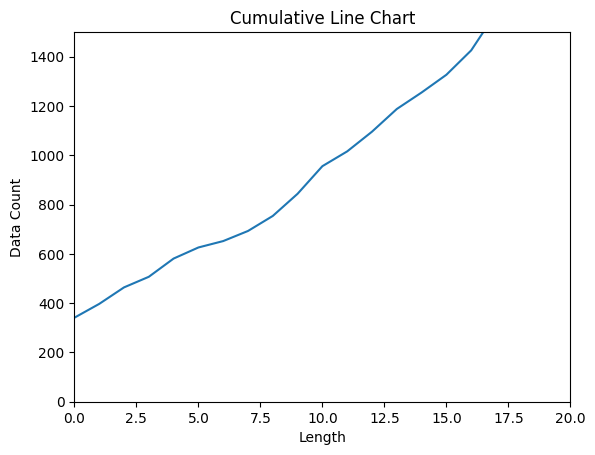

In [6]:
import matplotlib.pyplot as plt

# length 값에 따라 빈도수 계산
value_counts = df['length'].value_counts().sort_index()

# x, y 데이터 생성
x = value_counts.index.tolist()
y = value_counts.cumsum().tolist()
plt.xlim(0,500)
# 누적 선 그래프 생성
plt.plot(x, y)

# 그래프 속성 설정
plt.title('Cumulative Line Chart')
plt.xlabel('Length')
plt.ylabel('Data Count')
plt.xlim(0,20)
plt.ylim(0,1500)

# 그래프 출력
plt.show()

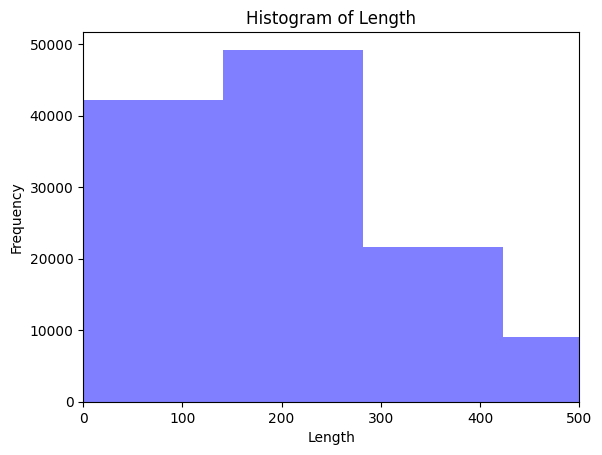

In [7]:
fig, ax = plt.subplots()
ax.hist(df[["length"]], bins=30, alpha=0.5, color='blue')
plt.xlim(0,500)
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Length')
plt.show()

In [8]:
print(df.tail())

                               _id  \
_idx                                 
128133.0  642259ea4b01b77a64e0c9dd   
128134.0  642259ea4b01b77a64e0c9de   
128135.0  642259ea4b01b77a64e0c9df   
128136.0  642259ea4b01b77a64e0c9e0   
128137.0  642259ea4b01b77a64e0c9e1   

                                                      token  length  
_idx                                                                 
128133.0  [사진/Noun, 제공/Noun, 더블/Noun, 앤/Noun, W/Alpha, 김...     163  
128134.0  [방탄소년단/Noun, 지민/Noun, 방탄소년단/Noun, 지민/Noun, 커리어...     214  
128135.0  [OSEN/Alpha, 민경/Noun, 기자/Noun, 지수/Noun, 솔로/Nou...     254  
128136.0  [페스티벌/Noun, 지금/Noun, 사진/Noun, 빅/Noun, 브라더스/Nou...     110  
128137.0  [서울/Noun, 뉴시스/Noun, 빌리다/Verb, Billlie/Alpha, E...     119  


### Gensim corpora model
- 참고 [link](https://wikidocs.net/30708)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 128607 entries, 28003.0 to 128137.0
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   _id     128607 non-null  object
 1   token   128607 non-null  object
 2   length  128607 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [14]:
# df.token 개수 10개 이하 삭제 처리
df = df[df['token'].apply(len) >= 10]
# 총 844개 탈락

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 127763 entries, 28003.0 to 128137.0
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   _id     127763 non-null  object
 1   token   127763 non-null  object
 2   length  127763 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [25]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(df.token)
corpus = [dictionary.doc2bow(text) for text in df.token]



In [ ]:
import pickle
dictionary.save('../pyrecommend-server/app/recommend_models/data/dictionary.pkl')
with open('../pyrecommend-server/app/recommend_models/data/corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [26]:
print(corpus[1])

[(10, 1), (21, 1), (34, 1), (60, 1), (68, 1), (85, 2), (95, 1), (98, 1), (112, 2), (115, 1), (157, 3), (168, 1), (209, 1), (210, 1), (211, 2), (212, 1), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 6), (220, 1), (221, 5), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 2), (235, 1), (236, 2), (237, 1), (238, 1), (239, 1), (240, 2), (241, 2), (242, 1), (243, 1), (244, 1), (245, 2), (246, 1), (247, 1), (248, 1), (249, 3), (250, 1), (251, 1), (252, 3), (253, 2), (254, 1), (255, 1), (256, 1), (257, 1), (258, 1), (259, 2), (260, 1), (261, 1), (262, 2), (263, 1), (264, 2), (265, 2), (266, 1), (267, 2), (268, 1), (269, 5), (270, 1), (271, 1), (272, 1), (273, 2), (274, 1), (275, 1), (276, 1), (277, 1), (278, 1), (279, 2), (280, 1), (281, 1), (282, 3), (283, 1), (284, 1), (285, 1), (286, 1), (287, 1), (288, 1), (289, 1), (290, 1), (291, 1), (292, 1), (293, 1), (294, 2), (295, 1), (296, 1), (297, 1

In [27]:
print(dictionary[8])

가운데/Noun


In [28]:
len(dictionary) # 전체 활용하고 있는 단어 갯수

133703

In [18]:
import gensim
NUM_TOPICS = 30 # 30개의 토픽
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, random_state=42,update_every=0, chunksize=10000,passes=20,alpha='auto',eta='auto',id2word=dictionary)

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(14, '0.026*"\u2008/Foreign" + 0.014*"주주/Noun" + 0.013*"받다/Verb" + 0.011*"보험/Noun"')
(27, '0.030*"의원/Noun" + 0.021*"민주당/Noun" + 0.020*"대표/Noun" + 0.017*"국민/Noun"')
(9, '0.052*"회장/Noun" + 0.038*"그룹/Noun" + 0.029*"선임/Noun" + 0.027*"사장/Noun"')
(26, '0.035*"미국/Noun" + 0.035*"한국/Noun" + 0.035*"중국/Noun" + 0.014*"일본/Noun"')
(2, '0.038*"AI/Alpha" + 0.018*"카카오/Noun" + 0.016*"제보/Noun" + 0.015*"kr/Alpha"')
(0, '0.038*"청년/Noun" + 0.019*"노동/Noun" + 0.018*"노조/Noun" + 0.017*"주/Noun"')
(11, '0.025*"방송/Noun" + 0.015*"사진/Noun" + 0.014*"기자/Noun" + 0.012*"2/Number"')
(18, '0.012*"환경/Noun" + 0.011*"연구/Noun" + 0.011*"에너지/Noun" + 0.009*"탄소/Noun"')
(20, '0.027*"도/Noun" + 0.024*"지역/Noun" + 0.022*"인천/Noun" + 0.017*"부산/Noun"')
(29, '0.040*"게임/Noun" + 0.013*"버스/Noun" + 0.011*"콘텐츠/Noun" + 0.010*"수/Noun"')
(1, '0.066*"서울/Noun" + 0.050*"기자/Noun" + 0.041*"3/Number" + 0.040*"1/Number"')
(5, '0.012*"시장/Noun" + 0.011*"기업/Noun" + 0.011*"생산/Noun" + 0.011*"기술/Noun"')
(8, '0.025*"수/Noun" + 0.016*"판매/Noun" + 0.016*"서비스/Noun"

In [ ]:
ldamodel.save('../pyrecommend-server/app/recommend_models/data/ldamodels.lda')

In [24]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

c:\Coding\S08P22A503\venv\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### Optimal Topic Number Determining
- 참고 [link](https://humboldt-wi.github.io/blog/research/information_systems_1819/is_lda_final/)
- jaccard similarity를 측정하여 그룹 간의 차이점이 잘 구분되는 시점을 탐색

In [32]:
import random
topicnums = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
project_folder = os.getcwd()

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    if not os.path.exists(project_folder+'\\models\\ldamodels_bow_'+str(i)+'.lda'):
        print('Creating LDA model with {} topics'.format(i))
        ldamodels_bow[i] = models.LdaModel(corpus, num_topics=i, random_state=42,update_every=0, chunksize=10000,passes=20,alpha='auto',eta='auto',id2word=dictionary)
        ldamodels_bow[i].save(project_folder+'\\models\\ldamodels_bow_'+str(i)+'.lda')
        print('ldamodels_bow_{}.lda created.'.format(i))
    else: 
        print('ldamodels_bow_{}.lda already exists.'.format(i))

Creating LDA model with 1 topics
ldamodels_bow_1.lda created.
Creating LDA model with 5 topics
ldamodels_bow_5.lda created.
Creating LDA model with 10 topics


KeyboardInterrupt: 

In [ ]:
lda_topics = {}
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/models/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

In [ ]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [ ]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims

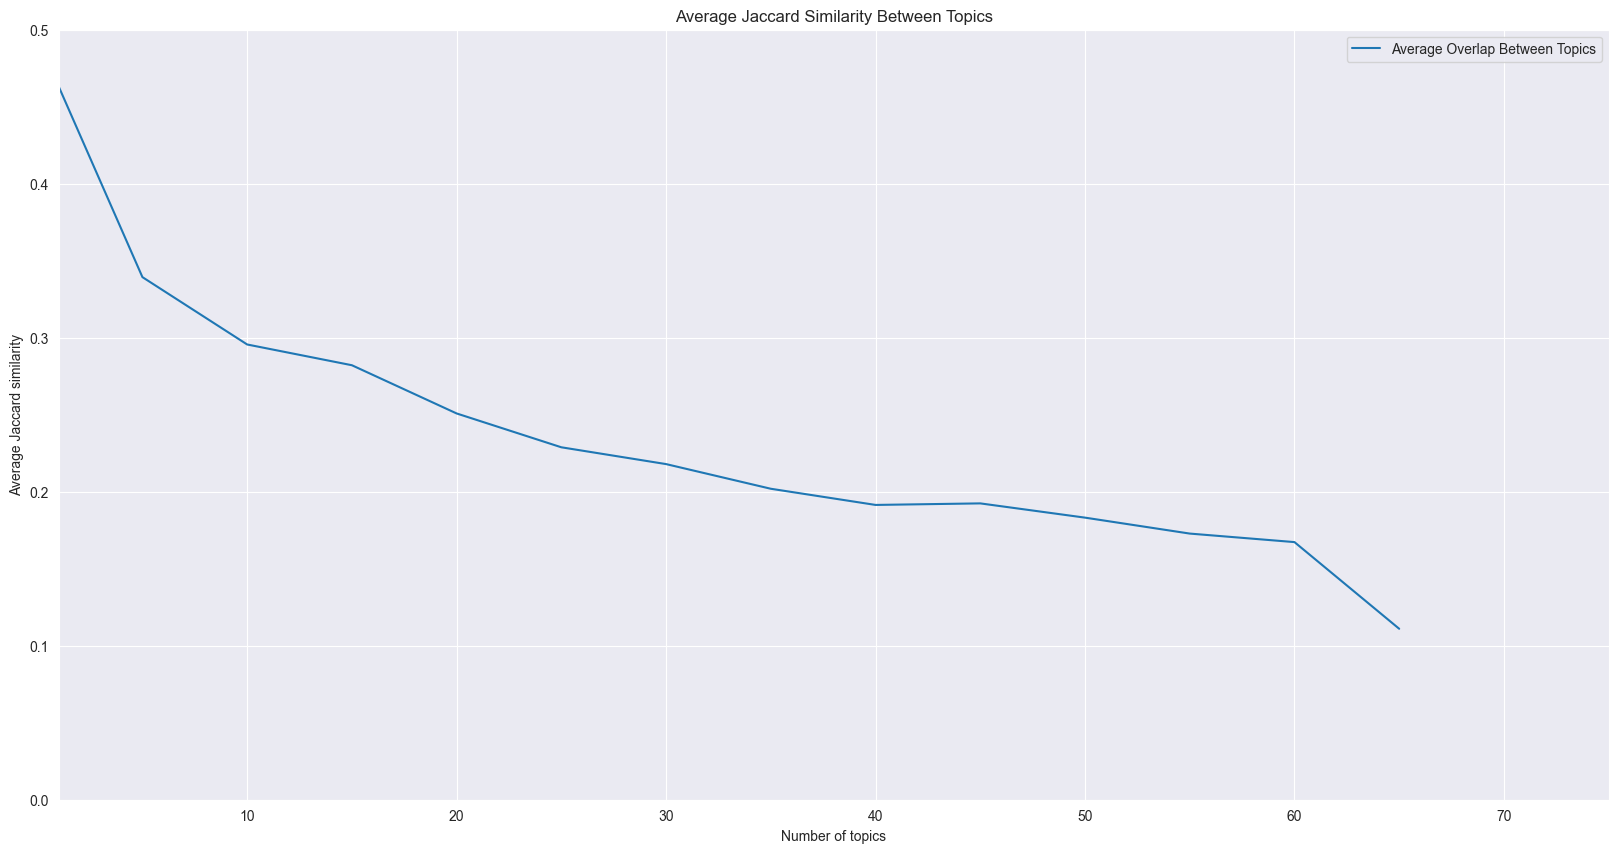

In [ ]:
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.figure(figsize=(20,10))
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 75])
    plt.ylim([0, 0.5])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()

### 추천 진행

In [ ]:
num_topics = 65
lda_model_final = models.LdaModel.load(project_folder+'/models/ldamodels_bow_'+str(num_topics)+'.lda')
lda_model_final.save('../pyrecommend-server/app/recommend_models/data/ldamodels.lda')
corpus_lda_model = lda_model_final[corpus]

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, dictionary)
pyLDAvis.display(vis)

In [ ]:
# %%cache mycache_lda_index.pkl index
index = similarities.MatrixSimilarity(lda_model_final[corpus])
index.save('../pyrecommend-server/app/recommend_models/data/ldaindex.sim')

In [ ]:
def book_recommender(idx):
    books_checked = 0
    for i in range(len(df.token)):
        recommendation_scores = []
        if i == idx:
            lda_vectors = corpus_lda_model[i]
            print("아마도 한개의 벡터",lda_vectors)
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                book_num = sim[0]
                recommendation_score = [df.title[book_num], sim[1],df.index[book_num],]
                recommendation_scores.append(recommendation_score)
            
            recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True)
            print("Your article's most prominent tokens are:")
            article_tokens = corpus[i]
            sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True)
            sorted_tokens_10 = sorted_tokens[:10]
            for i in range(len(sorted_tokens_10)):
                print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                             dictionary[sorted_tokens_10[i][0]], 
                                                             sorted_tokens_10[i][1]))
            print('-----')
            print("Your article's most prominant topic is:")
            print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(idx))
            display(recommendation[1:11])
        
        else:
            books_checked +=1
            

In [ ]:
book_recommender(300)

아마도 한개의 벡터 [(3, 0.018066522), (7, 0.015421404), (8, 0.013928107), (11, 0.011017182), (13, 0.034080453), (16, 0.030304482), (17, 0.04870288), (18, 0.010740764), (19, 0.022649288), (20, 0.05720388), (21, 0.034914885), (25, 0.015919918), (26, 0.11127497), (27, 0.120525055), (29, 0.019740786), (31, 0.019266121), (32, 0.038871426), (34, 0.011417946), (39, 0.030440694), (40, 0.02114665), (42, 0.033394195), (46, 0.026531437), (48, 0.059319098), (49, 0.011249074), (52, 0.022213107), (55, 0.040710937), (58, 0.036763914), (61, 0.0153145455), (64, 0.016289825)]
Your article's most prominent tokens are:
Word 10303 ("아이파크몰/NNP") appears 9 time(s).
Word 592 ("점/NNB") appears 8 time(s).
Word 10306 ("척/NNP") appears 8 time(s).
Word 1280 ("지역/NNG") appears 6 time(s).
Word 10280 ("개점/NNG") appears 5 time(s).
Word 10282 ("구로구/NNP") appears 5 time(s).
Word 769 ("식/NNB") appears 4 time(s).
Word 1225 ("동/NNP") appears 4 time(s).
Word 10278 ("HDC/SL") appears 4 time(s).
Word 0 ("10/SN") appears 3 time(s).
--

[['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', 1.0, 1626],
 ['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', 0.99999994, 1290],
 ['아이파크몰 고척점, 누적 방문객수 170만 명 돌파', 0.86939687, 5225],
 ['누구나 부모가 되지만, 아무나 부모가 될 수 없다', 0.83780134, 4949],
 ['누구나 부모가 되지만, 아무나 부모가 될 수 없다', 0.83766943, 5250],
 ["검찰, 'JMS 성폭행' 증인 출석 대비 피해자 보호 방안 논의", 0.8252579, 26779],
 ['법원장까지 재판…“제주에 판사가 없다”', 0.8204434, 25253],
 ['법원장까지 재판…“제주에 판사가 없다”', 0.82042855, 25235],
 ['법원장까지 재판…“제주에 판사가 없다”', 0.8204263, 27084],
 ['[단독]행안부 문경시 인근 상주추모공원건립 재검토 판정. 사업수정 불가피', 0.8092396, 24136]]

### 유저 경험 기반, 평균값으로 하는 추천

In [ ]:
def user_recommender(user_history):
    # Compute the user's average topic distribution
    user_topics = np.zeros(num_topics)
    for i in user_history:
        single_corpus = corpus_lda_model[i]
        for word in single_corpus:
            user_topics[word[0]] += word[1]
    user_average = user_topics / len(user_history)
    # Compute similarity scores between user history mean and all articles in corpus
    sims = index[user_average]
    # Create list of tuples with article index and similarity score
    sim_scores = list(enumerate(sims))

    # Sort list of tuples in descending order based on similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select top N articles with highest similarity scores
    N = 5
    top_n_indices = [i[0] for i in sim_scores[0:N+1]]
    print(top_n_indices)
    # Retrieve titles of recommended articles
    recommendations = df.loc[top_n_indices, "title"].tolist()
    print(f"Top {N} recommended articles based on user history:")
    print(recommendations)


In [ ]:
df_raw.iloc[1290]

_id                                      640aee622ad8d98d1d504d4d
_idx                                                          878
cat1                                                           경제
cat2                                                         생활경제
title                     "서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아
description     기사내용 요약 10일 공식 개점식 열어 HDC그룹 계열사 내 유통 전문 기업인 HD...
press                                                         뉴시스
link            https://n.news.naver.com/mnews/article/003/001...
publish_date                                  2023-03-10 17:30:11
full_text       기사내용 요약10일 공식 개점식 열어\n\n\n\n10일, 아이파크몰 고척점 개점식...
img_src         https://imgnews.pstatic.net/image/003/2023/03/...
Name: 1290, dtype: object

In [ ]:
df.loc[1290]

_id                                      640aee622ad8d98d1d504d4d
cat1                                                           경제
cat2                                                         생활경제
title                     "서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아
description     기사내용 요약 10일 공식 개점식 열어 HDC그룹 계열사 내 유통 전문 기업인 HD...
press                                                         뉴시스
link            https://n.news.naver.com/mnews/article/003/001...
publish_date                                  2023-03-10 17:30:11
full_text       기사내용 요약10일 공식 개점식 열어\n\n\n\n10일, 아이파크몰 고척점 개점식...
img_src         https://imgnews.pstatic.net/image/003/2023/03/...
token           [기사/NNG, 내용/NNG, 요약/NNG, 10/SN, 공식/NNG, 개점/NNG...
Name: 1290, dtype: object

In [ ]:
user_history = [300]
user_recommender(user_history)

[1290, 300, 1626, 5225, 4949, 5250]
Top 5 recommended articles based on user history:
['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', '"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', '"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', '아이파크몰 고척점, 누적 방문객수 170만 명 돌파', '누구나 부모가 되지만, 아무나 부모가 될 수 없다', '누구나 부모가 되지만, 아무나 부모가 될 수 없다']


### 유저 경험 기반 시간대 별로 weight 주기